## Task 3 (7 days)
#### In addition to focusing on macro system scheduling, we also plan to optimize profits from individual user characteristics.
#### In NYC, Uber's pricing plan consists of the following components：
1. A base rate
2. Toll and surcharges
3. Dynamic pricing
4. A booking or marketplace fee
5. Route based adjustments
6. Applicable promotions
7. Pool discounts

##### In addition to the starting price, distance fee, and fuel surcharge, Uber Rides also added a Dynamic Pricing item to dynamically adjust the price. This item is also one of the key points of profitability.
##### In task 1 on the 16th day and the 19th day, we have briefly discussed the general relationship between the travel cost and the start and end points, time, climate, etc. Now we need to uphold this idea and dig out the economic value.
##### In this link, you need to complete a clustering task: distinguish high-value customers through clustering, that is, determine what type of order users are willing to pay a higher price for, Find out which order was Urgent.
##### This task is even closely related to the origin and destination of orders, and the clustering algorithm is used to find "urgent orders/high-value orders". We can appropriately increase Dynamic Pricing for such high-value orders after the trip.
##### In this task, the effect of the basic K-means and its derivative algorithms may be mediocre, but we still recommend you to start practicing from kmeans and explore the basic order portrait.
##### For business-level models, you need to try DBSCAN, agglomerative hierarchical clustering, and try Deep Cluster if possible.
##### There are quite a lot of details for this task to explore, such as how to determine the Loss calculation of this task? The price in the data set is an order that has already taken place. How to find out whether passengers are willing to accept an increase in charges for this order? In the real model reasoning process, the price is neither an output nor an input, so what role does it play in this task？

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
import plotly.figure_factory as ff

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split

GRAND_OVER_PCA = False #True
PCA_COMPONENTS = 24 #8
N_CLUSTERS = 24 #any
SAMPLE_ONE_IN_K = 320 #any

In [2]:
def parquet_to_df(path):
    df = pq.read_table(path)
    df = df.to_pandas()
    return df

def extend_trips(ogdf, newdf):
    return ogdf.append(newdf, ignore_index=True)

def total_months_to_filename(total_months):
    months = [m[-2:]for m in ['0'+str(m) for m in list(range(1,total_months+1))]]
    trips = pd.DataFrame()

    for month in months:
        path = f'data/fhvhv_tripdata_2021-{month}.parquet'
        df = parquet_to_df(path)
        df = df.sample(n=len(df)//SAMPLE_ONE_IN_K, random_state=42)
        trips = extend_trips(trips, df)
    return trips

In [3]:
trips = total_months_to_filename(12)

In [4]:
key_series = ['base_passenger_fare', 'driver_pay']
threshold = 0
for series in key_series:
    percent = (trips[series] < threshold).mean() * 100
    print(f'{series} negative: {percent:.4f}%')
    percent = (trips[series] <= threshold).mean() * 100
    print(f'{series} <= zero: {percent:.4f}%')

original_row_count = len(trips)
condition = (trips['base_passenger_fare'] > 0) & (trips['driver_pay'] > 0)
trips_ = trips[condition]
filtered_row_count = len(trips_)
attrition_rate = ((original_row_count - filtered_row_count) / original_row_count) * 100
print(f'Data Entry Removal Rate: {attrition_rate:.4f}%')

trips_.head()

base_passenger_fare negative: 0.1155%
base_passenger_fare <= zero: 0.2264%
driver_pay negative: 0.0038%
driver_pay <= zero: 0.6649%
Data Entry Removal Rate: 0.8471%


,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02869,B02869,2021-01-12 13:20:00,2021-01-12 13:22:21,2021-01-12 13:22:21,2021-01-12 13:33:51,181,257,2.340,...,0.88,0.00,NaN,0.0,8.36,N,N,,N,N
1,HV0003,B02867,B02867,2021-01-01 19:12:57,2021-01-01 19:18:29,2021-01-01 19:20:01,2021-01-01 19:49:14,132,229,16.700,...,8.60,2.75,NaN,0.0,53.39,N,N,,N,N
2,HV0003,B02764,B02764,2021-01-31 14:15:46,2021-01-31 14:17:30,2021-01-31 14:17:30,2021-01-31 14:26:58,68,231,2.070,...,1.08,2.75,NaN,0.0,7.04,N,N,,N,N
3,HV0003,B02764,B02764,2021-01-09 15:36:38,2021-01-09 15:36:51,2021-01-09 15:38:51,2021-01-09 15:46:32,233,164,1.060,...,0.74,2.75,NaN,0.0,5.74,N,N,,N,N
4,HV0005,B02510,None,2021-01-07 16:24:13,NaT,2021-01-07 16:29:53,2021-01-07 16:40:36,216,197,2.051,...,0.87,0.00,NaN,0.0,7.66,N,N,N,N,N


In [5]:
weather_2021_path = "data/nyc 2021-01-01 to 2021-12-31.csv"
weather_2021 = pd.read_csv(weather_2021_path)

features = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 
            'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 
            'cloudcover', 'visibility', 'uvindex']

weather_2021 = weather_2021[['datetime']+features]

In [6]:
key_features = ['visibility', 'temp', 'feelslike', 'uvindex', 'humidity', 'snow', 'sealevelpressure']
key_ride_info = ['request_datetime', 'PULocationID', 'DOLocationID', 'base_passenger_fare', 'driver_pay']

essential_trips = trips_[key_ride_info].copy()
essential_weather_2021 = weather_2021[['datetime'] + key_features].copy()

In [7]:
essential_trips.loc[:, 'uber_revenue'] = essential_trips['base_passenger_fare'] - essential_trips['driver_pay']
essential_trips.loc[:, 'profit_to_fare_pct'] = essential_trips['uber_revenue'] / essential_trips['base_passenger_fare']
essential_trips['request_datetime'] = pd.to_datetime(essential_trips['request_datetime'])
essential_trips['date'] = essential_trips['request_datetime'].dt.date.copy()
essential_trips['weekday'] = essential_trips['request_datetime'].dt.weekday.copy()
essential_trips['hour'] = essential_trips['request_datetime'].dt.hour.copy()

In [8]:
weather_2021_df = weather_2021.copy()
weather_2021_df['datetime'] = pd.to_datetime(weather_2021_df['datetime'])
weather_2021_df['date'] = weather_2021_df['datetime'].dt.date

trips_weather_df = essential_trips.merge(weather_2021_df, on=['date'], how='left')

In [9]:
unfiltered_tw_df = trips_weather_df.copy()
trips_weather_df = trips_weather_df[trips_weather_df['profit_to_fare_pct'] >= -0.66]
trips_weather_df.head()

,request_datetime,PULocationID,DOLocationID,base_passenger_fare,driver_pay,uber_revenue,profit_to_fare_pct,date,weekday,hour,...,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex
0,2021-01-12 13:20:00,181,257,9.96,8.36,1.60,0.160643,2021-01-12,1,13,...,0.00,0.0,0.0,0.0,12.0,215.3,1019.5,15.9,15.4,5.0
1,2021-01-01 19:12:57,132,229,90.75,53.39,37.36,0.411680,2021-01-01,4,19,...,15.33,100.0,0.0,0.0,15.5,69.8,1028.9,50.6,14.0,3.0
2,2021-01-31 14:15:46,68,231,9.21,7.04,2.17,0.235613,2021-01-31,6,14,...,1.96,100.0,10.0,4.3,27.5,73.5,1025.3,65.3,12.7,2.0
3,2021-01-09 15:36:38,233,164,8.36,5.74,2.62,0.313397,2021-01-09,5,15,...,0.00,0.0,0.0,0.0,25.9,264.4,1012.2,52.4,16.0,5.0
4,2021-01-07 16:24:13,216,197,9.83,7.66,2.17,0.220753,2021-01-07,3,16,...,0.00,0.0,0.0,0.0,22.8,322.7,1018.5,7.6,16.0,5.0


In [10]:
cols = ['date', 'hour', 'PULocationID', 'DOLocationID', 'base_passenger_fare', 'uber_revenue','profit_to_fare_pct',
        'visibility', 'temp', 'feelslike', 'uvindex', 'humidity', 'snow', 'sealevelpressure','weekday']

trips_weather_df = trips_weather_df[cols].copy().dropna()
trips_weather_df.head()

,date,hour,PULocationID,DOLocationID,base_passenger_fare,uber_revenue,profit_to_fare_pct,visibility,temp,feelslike,uvindex,humidity,snow,sealevelpressure,weekday
0,2021-01-12,13,181,257,9.96,1.60,0.160643,15.4,3.2,1.1,5.0,55.7,0.0,1019.5,1
1,2021-01-01,19,132,229,90.75,37.36,0.411680,14.0,2.5,-0.2,3.0,67.8,0.0,1028.9,4
2,2021-01-31,14,68,231,9.21,2.17,0.235613,12.7,-4.9,-9.4,2.0,60.7,10.0,1025.3,6
3,2021-01-09,15,233,164,8.36,2.62,0.313397,16.0,-0.2,-4.6,5.0,49.9,0.0,1012.2,5
4,2021-01-07,16,216,197,9.83,2.17,0.220753,16.0,1.9,-2.1,5.0,54.9,0.0,1018.5,3


In [11]:
holidays_2021 = {
    "2021-01-01": "new_years_day",
    "2021-01-18": "martin_luther_king_jr_day",
    "2021-02-07": "super_bowl_sunday",
    "2021-02-15": "presidents_day",
    "2021-05-31": "memorial_day",
    "2021-06-19": "juneteenth",
    "2021-09-06": "labor_day",
    "2021-09-11": "patriot_day",
    "2021-10-11": "columbus_day",
    "2021-10-31": "halloween",
    "2021-11-25": "thanksgiving_day",
    "2021-12-25": "christmas_day",
}

holidays_df = pd.DataFrame(list(holidays_2021.items()), columns=['date', 'holiday_name'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

trips_weather_df['date'] = pd.to_datetime(trips_weather_df['date'])
trips_weather_df = trips_weather_df.merge(holidays_df, on='date', how='left')

for holiday in holidays_2021.values():
    trips_weather_df[holiday] = trips_weather_df['holiday_name'] == holiday

trips_weather_df = trips_weather_df.drop(columns=['holiday_name'])
holiday_columns = list(holidays_2021.values())

trips_weather_df.head()

,date,hour,PULocationID,DOLocationID,base_passenger_fare,uber_revenue,profit_to_fare_pct,visibility,temp,feelslike,...,super_bowl_sunday,presidents_day,memorial_day,juneteenth,labor_day,patriot_day,columbus_day,halloween,thanksgiving_day,christmas_day
0,2021-01-12,13,181,257,9.96,1.60,0.160643,15.4,3.2,1.1,...,False,False,False,False,False,False,False,False,False,False
1,2021-01-01,19,132,229,90.75,37.36,0.411680,14.0,2.5,-0.2,...,False,False,False,False,False,False,False,False,False,False
2,2021-01-31,14,68,231,9.21,2.17,0.235613,12.7,-4.9,-9.4,...,False,False,False,False,False,False,False,False,False,False
3,2021-01-09,15,233,164,8.36,2.62,0.313397,16.0,-0.2,-4.6,...,False,False,False,False,False,False,False,False,False,False
4,2021-01-07,16,216,197,9.83,2.17,0.220753,16.0,1.9,-2.1,...,False,False,False,False,False,False,False,False,False,False


In [12]:
input_df = trips_weather_df[['PULocationID', 'DOLocationID', 'hour', 'weekday', 'profit_to_fare_pct']]
input_df.head()

,PULocationID,DOLocationID,hour,weekday,profit_to_fare_pct
0,181,257,13,1,0.160643
1,132,229,19,4,0.411680
2,68,231,14,6,0.235613
3,233,164,15,5,0.313397
4,216,197,16,3,0.220753


In [13]:
dummies_PU = pd.get_dummies(input_df['PULocationID'], prefix='PU')
dummies_DO = pd.get_dummies(input_df['DOLocationID'], prefix='DO')
dummies_h = pd.get_dummies(input_df['hour'], prefix='h')
dummies_w = pd.get_dummies(input_df['weekday'], prefix='w')

input_df_dummies = pd.concat([dummies_PU, dummies_DO, dummies_h, dummies_w], axis=1)
input_df_dummies.head()

,PU_1,PU_2,PU_3,PU_4,PU_5,PU_6,PU_7,PU_8,PU_9,PU_10,...,h_21,h_22,h_23,w_0,w_1,w_2,w_3,w_4,w_5,w_6
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [14]:
columns = ['date', 'profit_to_fare_pct', 'base_passenger_fare', 'uber_revenue',
           'visibility', 'temp', 'feelslike', 'uvindex', 'humidity', 'snow', 'sealevelpressure']

grand_input = pd.concat([trips_weather_df[columns].copy(), input_df_dummies], axis=1)
grand_input.head()

,date,profit_to_fare_pct,base_passenger_fare,uber_revenue,visibility,temp,feelslike,uvindex,humidity,snow,...,h_21,h_22,h_23,w_0,w_1,w_2,w_3,w_4,w_5,w_6
0,2021-01-12,0.160643,9.96,1.60,15.4,3.2,1.1,5.0,55.7,0.0,...,0,0,0,0,1,0,0,0,0,0
1,2021-01-01,0.411680,90.75,37.36,14.0,2.5,-0.2,3.0,67.8,0.0,...,0,0,0,0,0,0,0,1,0,0
2,2021-01-31,0.235613,9.21,2.17,12.7,-4.9,-9.4,2.0,60.7,10.0,...,0,0,0,0,0,0,0,0,0,1
3,2021-01-09,0.313397,8.36,2.62,16.0,-0.2,-4.6,5.0,49.9,0.0,...,0,0,0,0,0,0,0,0,1,0
4,2021-01-07,0.220753,9.83,2.17,16.0,1.9,-2.1,5.0,54.9,0.0,...,0,0,0,0,0,0,1,0,0,0


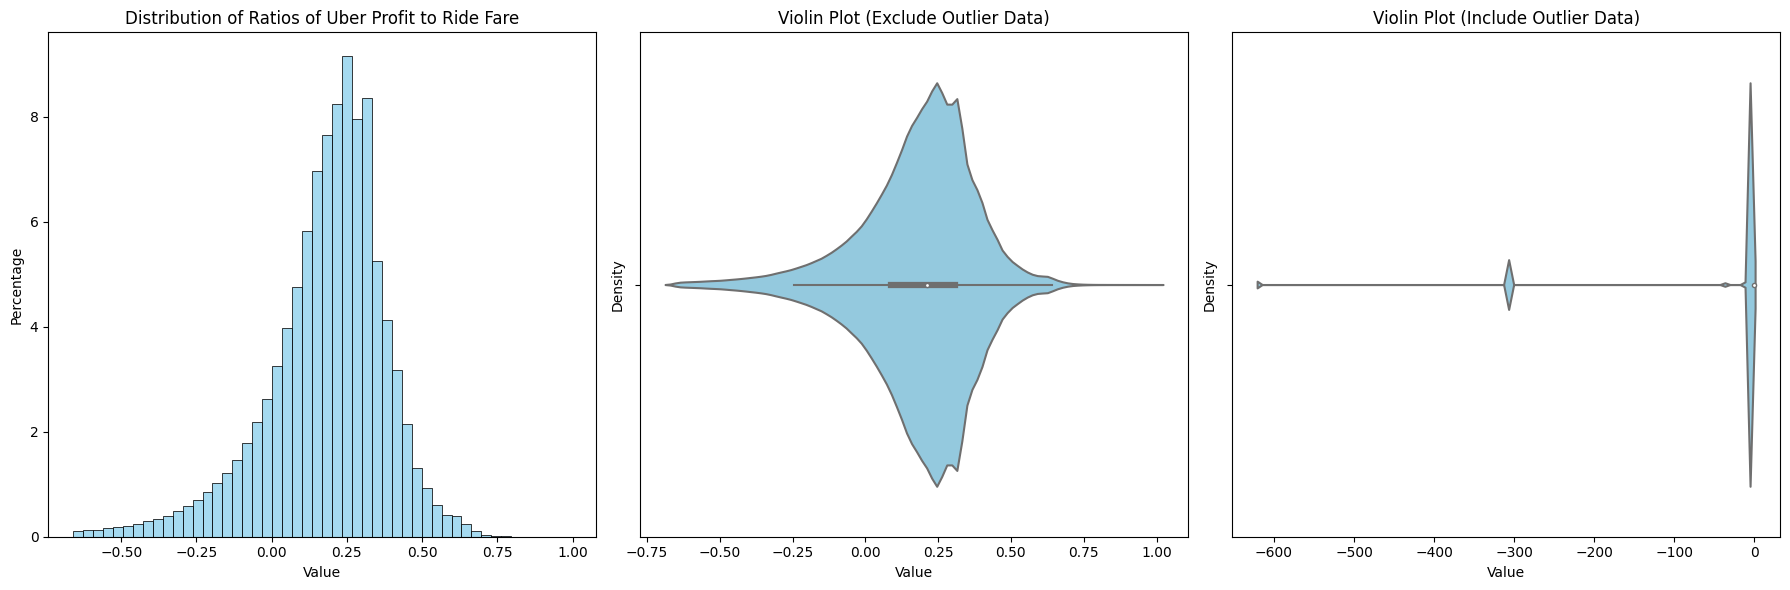

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(trips_weather_df['profit_to_fare_pct'], 
             bins=50, kde=False, color='skyblue', edgecolor='black', stat='percent', ax=axs[0])
axs[0].set_title('Distribution of Ratios of Uber Profit to Ride Fare')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Percentage')

sns.violinplot(x=trips_weather_df['profit_to_fare_pct'], color='skyblue', ax=axs[1])
axs[1].set_title('Violin Plot (Exclude Outlier Data)')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')

sns.violinplot(x=unfiltered_tw_df['profit_to_fare_pct'], color='skyblue', ax=axs[2])
axs[2].set_title('Violin Plot (Include Outlier Data)')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Density')

plt.tight_layout()
plt.show()

#### Data Preprocessing

In [16]:
scaler = StandardScaler()
grand_input_X_norm = scaler.fit_transform(grand_input.iloc[:,2:])

pca = PCA(n_components=PCA_COMPONENTS)
pca_transformed = pca.fit_transform(grand_input_X_norm)

pca_df = pd.DataFrame(pca_transformed, columns=[f'PC{i+1}' for i in range(PCA_COMPONENTS)])
pca_df['profit_to_fare_pct'] = grand_input['profit_to_fare_pct'].values
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,profit_to_fare_pct
0,-1.623986,-0.866501,0.312097,0.241683,-1.292701,-1.095622,0.211021,0.327250,-0.210003,0.704167,...,1.352585,-0.018972,1.750088,0.162289,1.085096,0.467426,0.823453,-1.129257,-0.986448,0.160643
1,0.228716,3.108785,6.057360,0.501419,0.082229,0.279488,1.111992,-0.235086,0.406695,-0.436831,...,0.417452,-0.482745,0.263803,0.926964,-0.239820,-0.508598,-0.609620,1.018122,-0.566263,0.411680
2,-5.775091,1.657678,1.568127,0.085154,-0.112763,-0.652412,-1.162882,0.740681,-0.799917,-0.866526,...,0.029873,0.561921,0.029235,0.473597,0.302245,-0.217396,0.597013,-0.417197,-0.539755,0.235613
3,-1.771412,-0.820911,0.984088,-0.026886,-0.008878,-0.635699,-1.642142,1.052718,-0.888155,0.051098,...,0.555443,1.055957,-1.066759,-0.738969,0.240607,-0.324879,-0.025410,0.476149,0.696817,0.313397
4,-1.975676,-0.906640,-0.181768,0.079823,-1.023546,3.717217,0.589270,-0.234641,-2.182221,-0.784994,...,0.125870,-1.598235,-1.988820,-0.898344,0.963351,-0.815354,-0.503055,-3.100127,-1.364223,0.220753


#### Pickup and Dropoff Location Analysis

In [17]:
if GRAND_OVER_PCA:
    df = grand_input.copy()
    X = df.iloc[:,1:].copy()
else:
    df = pca_df.copy()
    X = df.iloc[:,:-1].copy()

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

df['Urgent'] = df['profit_to_fare_pct'] > 0.4

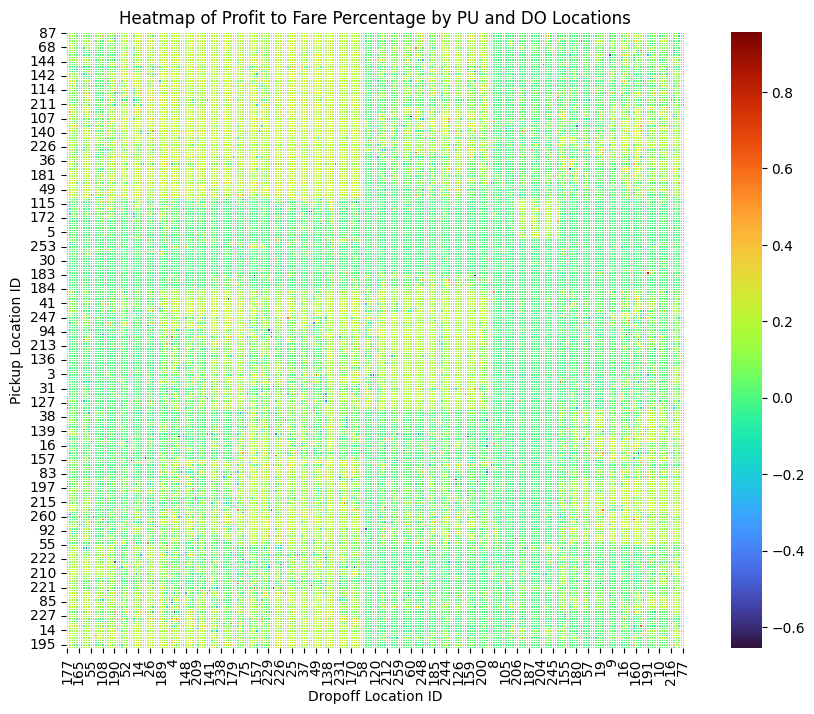

In [18]:
dummies_PU = pd.get_dummies(input_df['PULocationID'], prefix='PU')
dummies_DO = pd.get_dummies(input_df['DOLocationID'], prefix='DO')

heatmap_data = input_df.pivot_table(index='PULocationID', columns='DOLocationID', 
                                    values='profit_to_fare_pct', aggfunc='mean', fill_value=0)

Z_cols = linkage(heatmap_data.T, 'ward')
col_order = leaves_list(Z_cols)
Z_rows = linkage(heatmap_data, 'ward')
row_order = leaves_list(Z_rows)

clustered_df = heatmap_data.iloc[row_order, col_order]
cmap = sns.color_palette("turbo", as_cmap=True)
plt.figure(figsize=(12, 8))
ax = sns.heatmap(clustered_df, cmap=cmap, linewidths=.7, cbar=True, square=True, 
                 annot=False, fmt=".2f", vmin=clustered_df.min().min(), vmax=clustered_df.max().max())

ax.set_title('Heatmap of Profit to Fare Percentage by PU and DO Locations')
ax.set_xlabel('Dropoff Location ID')
ax.set_ylabel('Pickup Location ID')
plt.show()

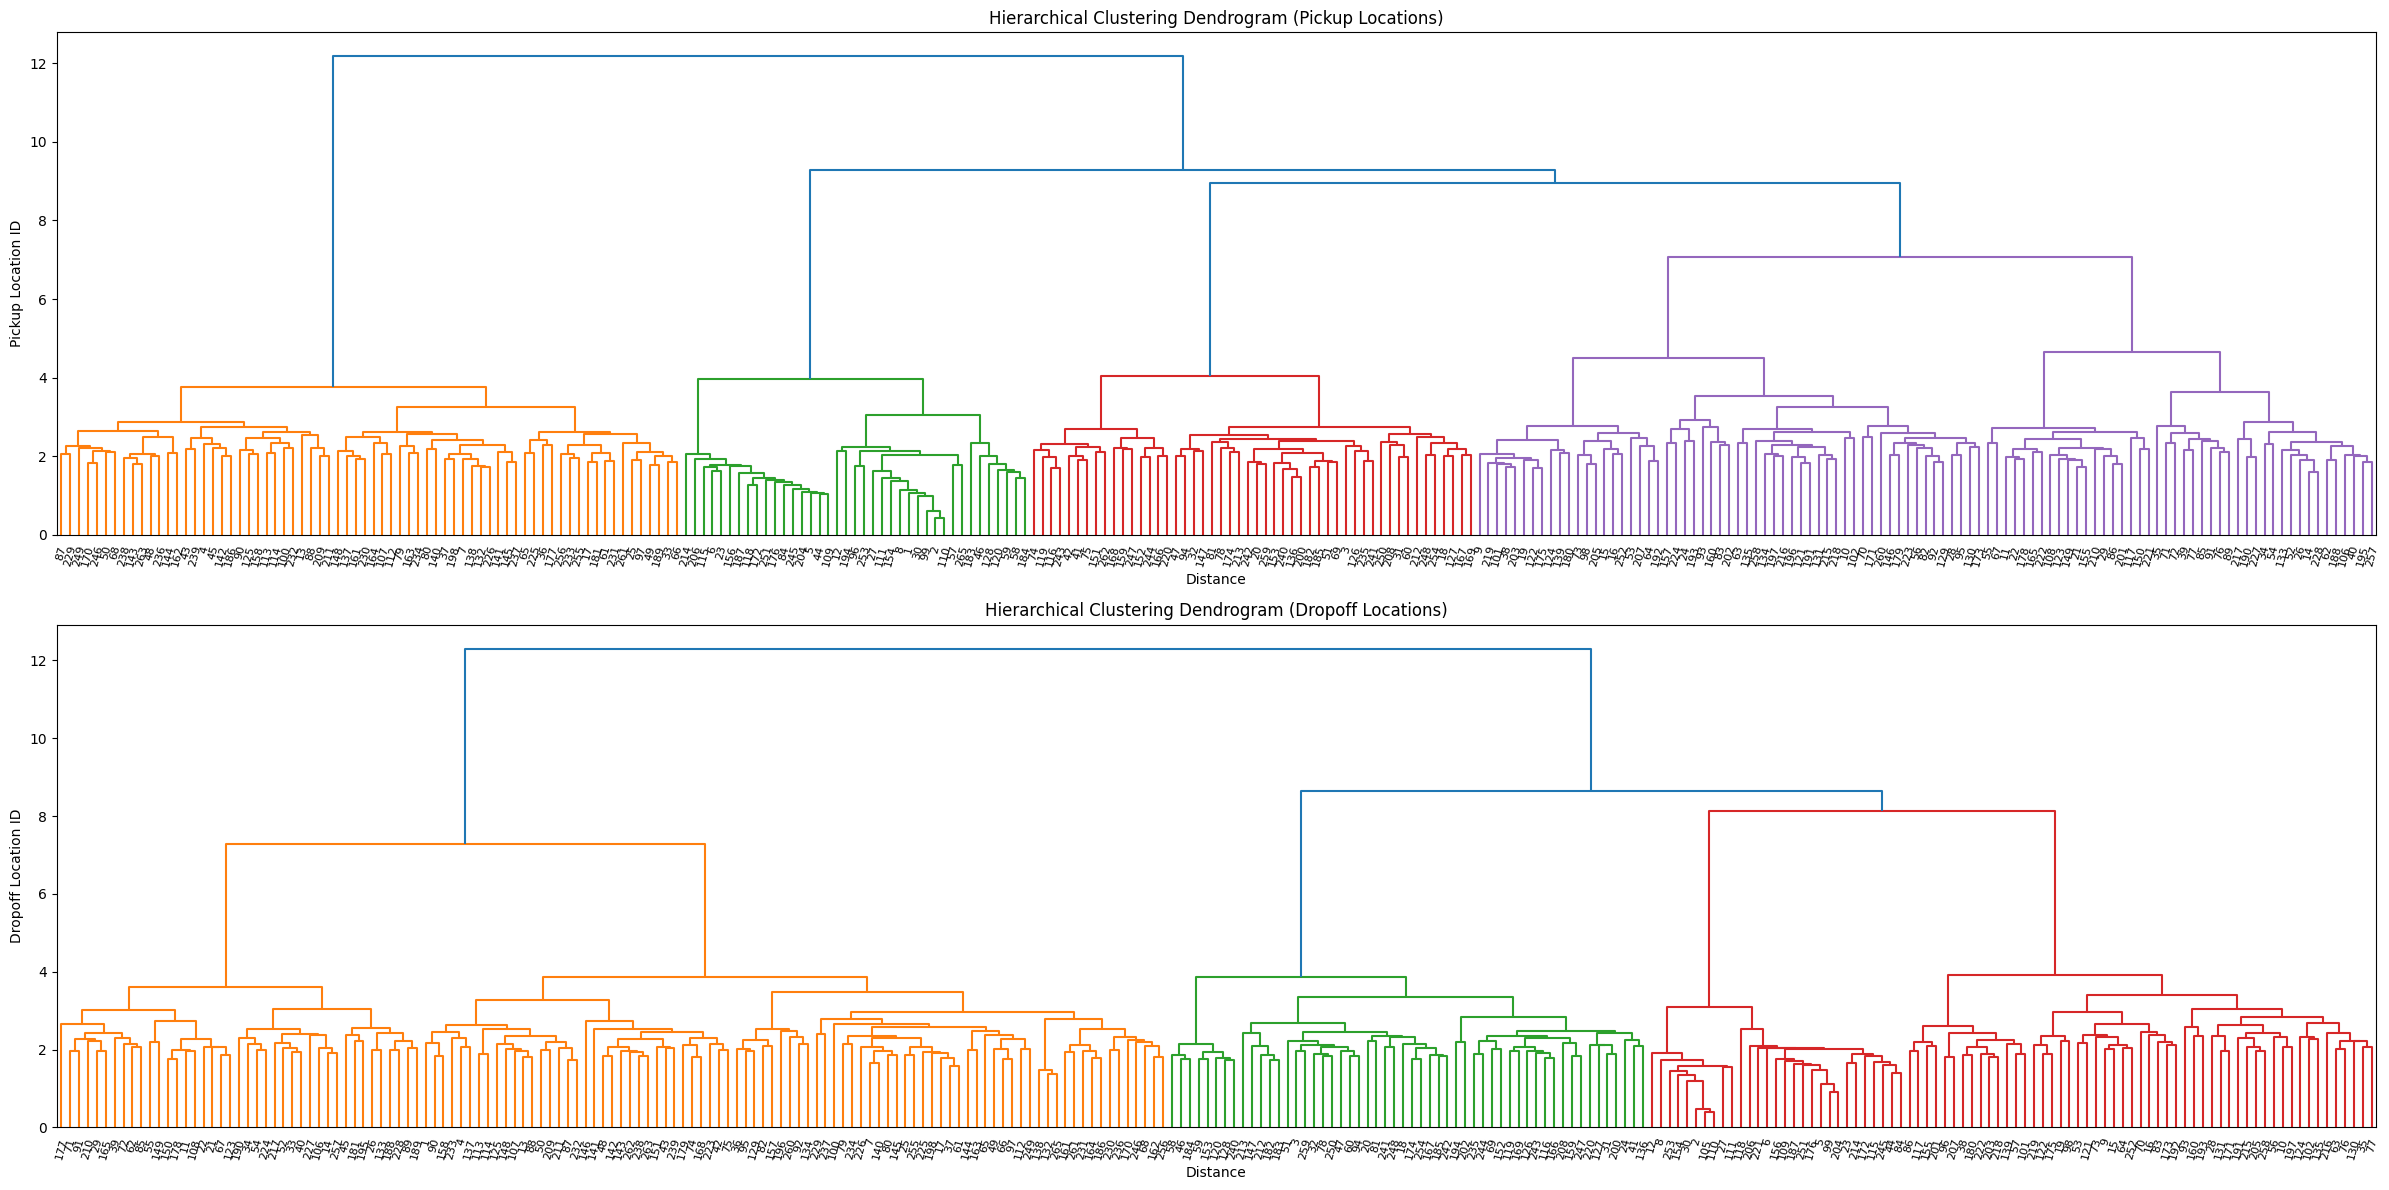

In [19]:
Z_pu = linkage(heatmap_data, method='ward')
Z_do = linkage(heatmap_data.T, method='ward')
plt.figure(figsize=(24, 12))

plt.subplot(211)
dendrogram(Z_pu, labels=heatmap_data.index, orientation='top', leaf_rotation=75, leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram (Pickup Locations)')
plt.xlabel('Distance')
plt.ylabel('Pickup Location ID')

plt.subplot(212)
dendrogram(Z_do, labels=heatmap_data.columns, orientation='top', leaf_rotation=75, leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram (Dropoff Locations)')
plt.xlabel('Distance')
plt.ylabel('Dropoff Location ID')

plt.tight_layout()
plt.show()

In [20]:
fig_pu = ff.create_dendrogram(heatmap_data, orientation='bottom', labels=heatmap_data.index.tolist())
fig_pu.update_layout(
    width=1400,
    height=350,
    title='Hierarchical Clustering Dendrogram (Pickup Locations)',
    xaxis_title='Pickup Location ID',
    yaxis_title='Distance'
)
fig_pu.show()

fig_do = ff.create_dendrogram(heatmap_data.T, orientation='bottom', labels=heatmap_data.columns.tolist())
fig_do.update_layout(
    width=1400,
    height=350,
    title='Hierarchical Clustering Dendrogram (Dropoff Locations)',
    xaxis_title='Dropoff Location ID',
    yaxis_title='Distance'
)
fig_do.show()

#### Deep Clustering

In [21]:
class AutoencoderDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name()}")

Using device: NVIDIA GeForce RTX 3060 Laptop GPU


In [23]:
X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
y_tensor = torch.tensor(df['profit_to_fare_pct'].values, dtype=torch.float32).view(-1, 1)

dataset = AutoencoderDataset(X_tensor, y_tensor)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_dim = X_tensor.shape[1]
autoencoder = Autoencoder(input_dim).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 500
best_val_loss = float('inf')
patience = 10
early_stop_counter = 0

In [24]:
for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        optimizer.zero_grad()
        reconstructed, _ = autoencoder(X_batch)
        loss = criterion(reconstructed, X_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    
    autoencoder.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            
            reconstructed, _ = autoencoder(X_batch)
            loss = criterion(reconstructed, X_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Epoch 1/500, Train Loss: 0.237485, Val Loss: 0.163173
Epoch 2/500, Train Loss: 0.150883, Val Loss: 0.143447
Epoch 3/500, Train Loss: 0.137883, Val Loss: 0.134389
Epoch 4/500, Train Loss: 0.130646, Val Loss: 0.129730
Epoch 5/500, Train Loss: 0.125587, Val Loss: 0.125218
Epoch 6/500, Train Loss: 0.122232, Val Loss: 0.121661
Epoch 7/500, Train Loss: 0.119608, Val Loss: 0.122072
Epoch 8/500, Train Loss: 0.117211, Val Loss: 0.119821
Epoch 9/500, Train Loss: 0.115486, Val Loss: 0.115872
Epoch 10/500, Train Loss: 0.113986, Val Loss: 0.114985
Epoch 11/500, Train Loss: 0.112818, Val Loss: 0.114405
Epoch 12/500, Train Loss: 0.111873, Val Loss: 0.116441
Epoch 13/500, Train Loss: 0.111059, Val Loss: 0.114014
Epoch 14/500, Train Loss: 0.110278, Val Loss: 0.110726
Epoch 15/500, Train Loss: 0.109689, Val Loss: 0.110381
Epoch 16/500, Train Loss: 0.109175, Val Loss: 0.110240
Epoch 17/500, Train Loss: 0.108597, Val Loss: 0.109987
Epoch 18/500, Train Loss: 0.108010, Val Loss: 0.108191
Epoch 19/500, Train

In [25]:
autoencoder.eval()
encoded_data = []
profit_to_fare_pct_values = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        _, encoded_batch = autoencoder(X_batch)
        encoded_data.append(encoded_batch.cpu().numpy())
        profit_to_fare_pct_values.append(y_batch.cpu().numpy())

encoded_data = np.vstack(encoded_data)
profit_to_fare_pct_values = np.concatenate(profit_to_fare_pct_values)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data)

df['deep_cluster'] = np.nan
df.loc[test_loader.dataset.indices, 'deep_cluster'] = cluster_labels
deep_cluster_analysis = df.groupby('deep_cluster')['profit_to_fare_pct'].mean()
print(deep_cluster_analysis)

deep_cluster
0.0     0.167482
1.0     0.172556
2.0     0.159416
3.0     0.181928
4.0     0.162193
5.0     0.172276
6.0     0.300351
7.0     0.168919
8.0     0.174613
9.0     0.165431
10.0    0.160355
11.0    0.173765
12.0    0.189591
13.0    0.161750
14.0    0.166843
15.0    0.177722
16.0    0.178574
17.0    0.262665
18.0    0.155273
19.0    0.148888
20.0    0.159109
21.0    0.181837
22.0    0.141400
23.0    0.160196
Name: profit_to_fare_pct, dtype: float64


In [26]:
mean = df[df['deep_cluster'] == 22]['Urgent'].mean()
print(f'Group 22 Urgent Rate: {mean}')
df[df['deep_cluster'] == 22].head()

Group 22 Urgent Rate: 0.026490066225165563


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,profit_to_fare_pct,Urgent,deep_cluster
1763,-0.932769,0.609397,1.918182,0.545566,0.005141,1.151982,2.318992,-0.593074,-0.756656,7.529825,...,-1.582358,-0.640098,-1.468402,1.729078,6.505408,1.068903,2.271041,0.030648,False,22.0
3107,-0.971973,0.766592,3.164409,0.474340,-0.002392,1.597197,2.637790,-0.281497,-0.802051,7.058724,...,0.276451,0.155038,0.713025,-0.758187,-1.567704,0.585216,-0.732445,0.150943,False,22.0
4749,-0.494648,0.999900,2.366815,0.595516,-0.261082,0.923436,1.762853,-0.236537,-0.088117,7.394959,...,-1.564833,1.007320,-1.584386,1.989393,7.365031,1.055774,3.529525,0.135120,False,22.0
6053,-1.170191,2.315045,0.860559,0.159274,-0.062193,1.141592,1.419847,-0.775219,-1.174316,7.950574,...,-0.513551,0.258744,0.693326,-1.170174,-1.639661,0.324051,-0.406348,0.048090,False,22.0
8868,-1.538604,-0.370447,0.824187,0.149157,-0.808429,2.796054,1.428287,-0.544094,-3.668505,8.431264,...,1.401582,0.296634,-1.443190,-0.907269,-2.358020,-1.977041,1.704259,0.253311,False,22.0


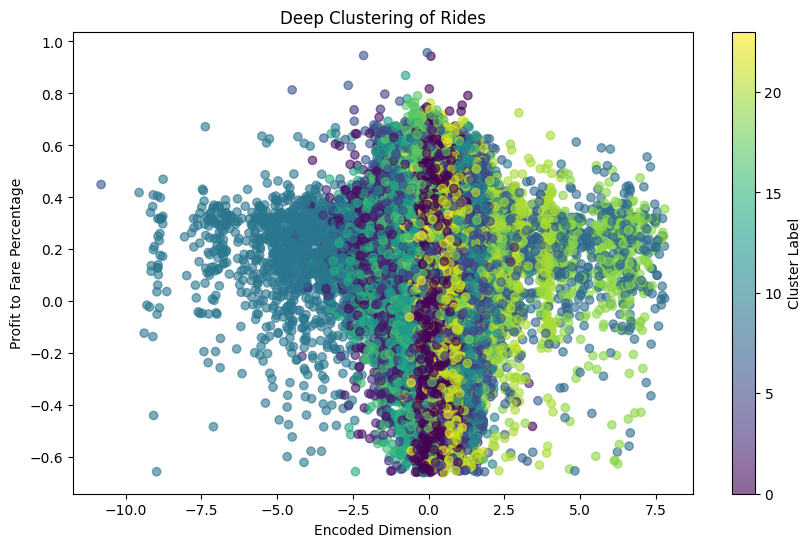

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(encoded_data[:, 0], profit_to_fare_pct_values, c=cluster_labels, cmap='viridis', alpha=0.6)
plt.title('Deep Clustering of Rides')
plt.xlabel('Encoded Dimension')
plt.ylabel('Profit to Fare Percentage')
plt.colorbar(label='Cluster Label')
plt.show()

#### Deep Learning Model for Urgency Index

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, df['profit_to_fare_pct'].values, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [29]:
class ProfitFareNet(nn.Module):
    def __init__(self):
        super(ProfitFareNet, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = ProfitFareNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
num_epochs = 500
checks = [i for i in range(1, num_epochs + 1) if i % (num_epochs // 100) == 0]

patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    if epoch + 1 in checks:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {1000*train_loss:.4f}, Val Loss: {1000*val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

Epoch 5/500, Train Loss: 14.2404, Val Loss: 14.1790
Epoch 10/500, Train Loss: 13.3186, Val Loss: 13.4622
Epoch 15/500, Train Loss: 12.8577, Val Loss: 13.1244
Epoch 20/500, Train Loss: 12.5628, Val Loss: 12.9045
Epoch 25/500, Train Loss: 12.3424, Val Loss: 12.9000
Epoch 30/500, Train Loss: 12.1915, Val Loss: 12.8224
Epoch 35/500, Train Loss: 12.0459, Val Loss: 12.7428
Epoch 40/500, Train Loss: 11.9562, Val Loss: 12.6027
Epoch 45/500, Train Loss: 11.8757, Val Loss: 12.5247
Epoch 50/500, Train Loss: 11.8033, Val Loss: 12.6810
Epoch 55/500, Train Loss: 11.7363, Val Loss: 12.5186
Epoch 60/500, Train Loss: 11.6805, Val Loss: 12.4845
Epoch 65/500, Train Loss: 11.6282, Val Loss: 12.5465
Epoch 70/500, Train Loss: 11.5716, Val Loss: 12.4352
Epoch 75/500, Train Loss: 11.5336, Val Loss: 12.3980
Epoch 80/500, Train Loss: 11.4956, Val Loss: 12.4358
Epoch 85/500, Train Loss: 11.4684, Val Loss: 12.4322
Epoch 90/500, Train Loss: 11.4314, Val Loss: 12.2371
Epoch 95/500, Train Loss: 11.4014, Val Loss: 12

In [31]:
model.eval()
predictions = []
test_loss = 0.0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {1000*test_loss:.4f}')

Test Loss: 12.6034


In [32]:
preds_urgent_threshold = 0.4

predictions = np.vstack(predictions)
predicted_urgency = (predictions > preds_urgent_threshold).astype(int)
true_urgency = (y_test > 0.4).astype(int)

classification_report_dl = classification_report(true_urgency, predicted_urgency.flatten())
roc_auc_dl = roc_auc_score(true_urgency, predicted_urgency)
print("Deep Learning Model - Classification Report:")
print(classification_report_dl)
print(f"ROC-AUC Score: {roc_auc_dl:.6f}")

Deep Learning Model - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     72984
           1       0.58      0.35      0.44      7373

    accuracy                           0.92     80357
   macro avg       0.76      0.66      0.70     80357
weighted avg       0.90      0.92      0.91     80357

ROC-AUC Score: 0.663050


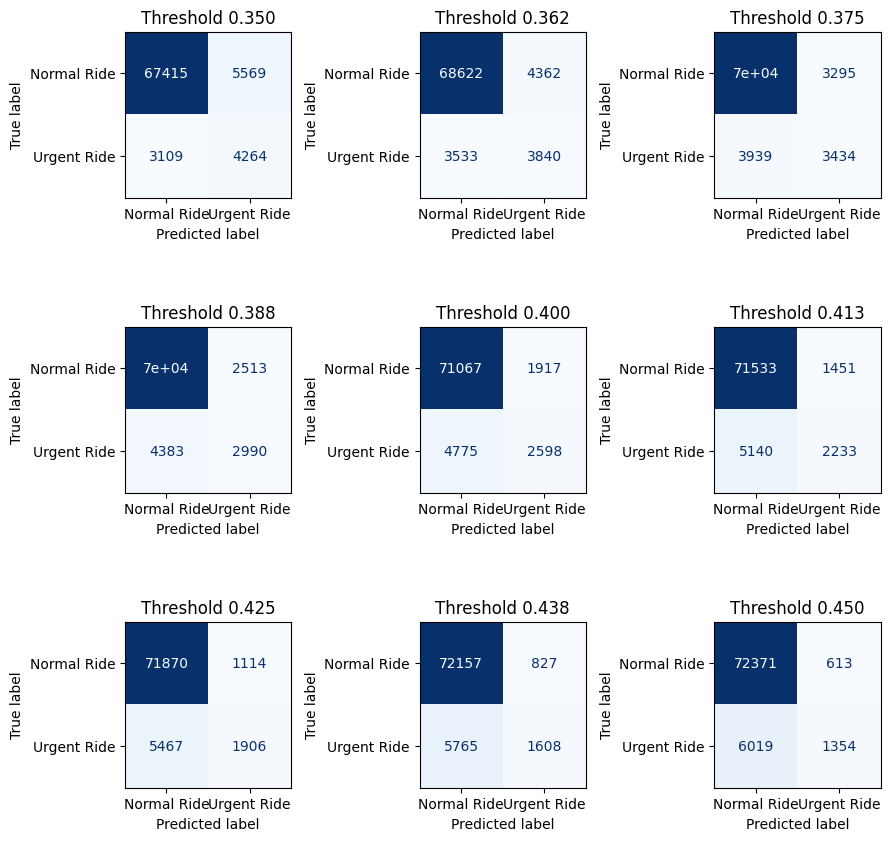

In [33]:
#thresholds = np.arange(0.2, 0.41, 0.025)
thresholds = np.arange(0.35, 0.451, 0.0125)

recalls = []
precisions = []
f1_scores = []
confusion_matrices = []

fig_conf, axs_conf = plt.subplots(3, 3, figsize=(9, 9))
axs_conf = axs_conf.flatten()

for i, threshold in enumerate(thresholds):
    predicted_urgency = (predictions > threshold).astype(int)
    true_urgency = (y_test > 0.4).astype(int)

    recall = recall_score(true_urgency, predicted_urgency.flatten(), pos_label=1)
    precision = precision_score(true_urgency, predicted_urgency.flatten(), pos_label=1)
    f1 = f1_score(true_urgency, predicted_urgency.flatten(), pos_label=1)
    roc_auc = roc_auc_score(true_urgency, predictions.flatten())
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

    cm = confusion_matrix(true_urgency, predicted_urgency.flatten(), labels=[0, 1])
    confusion_matrices.append(cm)

    if i < 9:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal Ride', 'Urgent Ride'])
        disp.plot(ax=axs_conf[i], cmap='Blues', colorbar=False)
        axs_conf[i].set_title(f'Threshold {threshold:.3f}')

plt.tight_layout()

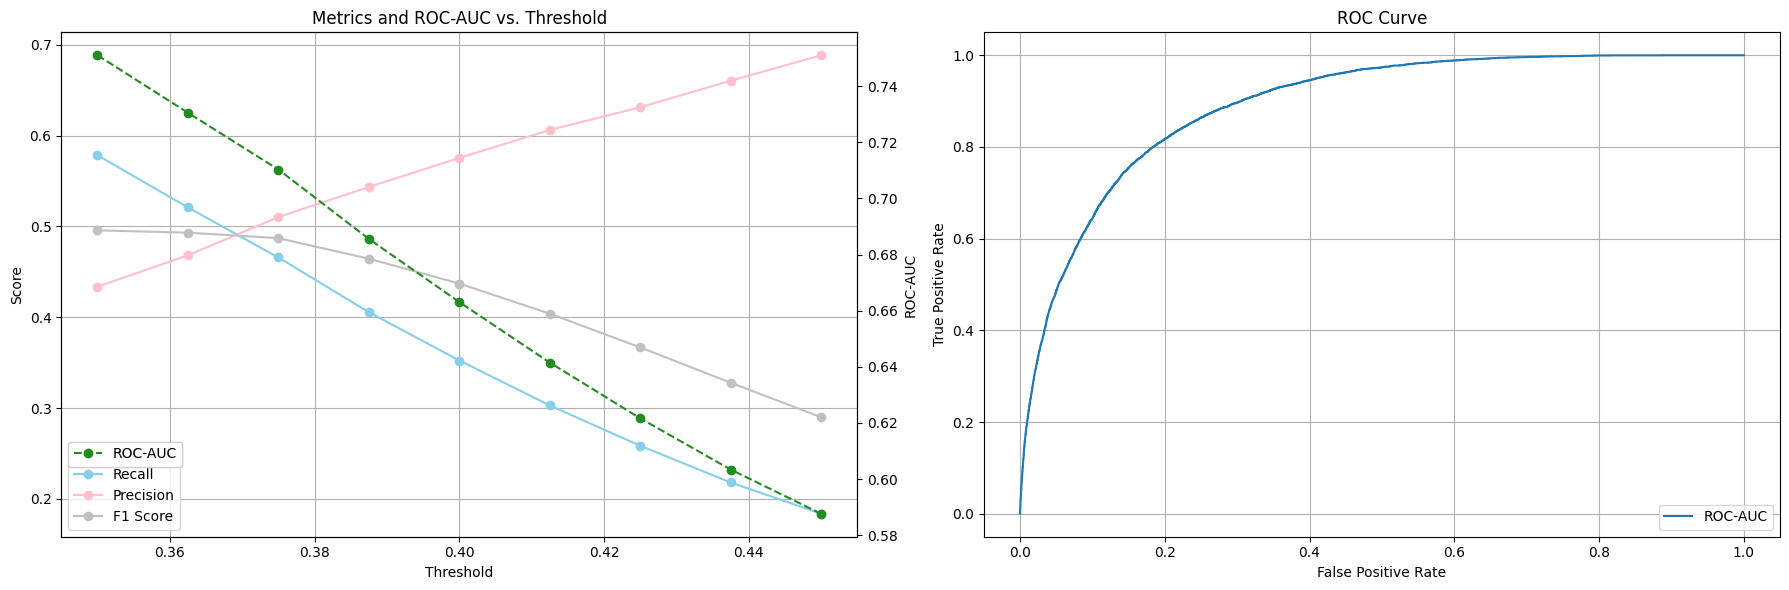

In [34]:
recalls = []
precisions = []
f1_scores = []
roc_auc_values = []
fpr_list = []
tpr_list = []

for threshold in thresholds:
    predicted_urgency = (predictions > threshold).astype(int)
    true_urgency = (y_test > 0.4).astype(int)
    recall = recall_score(true_urgency, predicted_urgency.flatten(), pos_label=1)
    precision = precision_score(true_urgency, predicted_urgency.flatten(), pos_label=1)
    f1 = f1_score(true_urgency, predicted_urgency.flatten(), pos_label=1)
    roc_auc = roc_auc_score(true_urgency, predicted_urgency)
    
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)
    roc_auc_values.append(roc_auc)

    fpr, tpr, _ = roc_curve(true_urgency, predictions.flatten(), pos_label=1)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
ax1 = axs[0]
ax1.plot(thresholds, recalls, marker='o', label='Recall', color='skyblue')
ax1.plot(thresholds, precisions, marker='o', label='Precision', color='pink')
ax1.plot(thresholds, f1_scores, marker='o', label='F1 Score', color='silver')

ax2 = ax1.twinx()
ax2.plot(thresholds, roc_auc_values, marker='o', color='forestgreen', linestyle='--', label='ROC-AUC')

ax1.set_title('Metrics and ROC-AUC vs. Threshold')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax2.set_ylabel('ROC-AUC')

ax1.legend(loc='lower left')
roc_auc_legend = ax2.legend(loc='lower left', bbox_to_anchor=(0, 0))
roc_auc_legend.set_bbox_to_anchor((0, 0.125), transform=ax2.transAxes)
ax2.add_artist(roc_auc_legend)

ax1.grid(True)

ax3 = axs[1]
ax3.plot(fpr_list[5], tpr_list[5], label=f'ROC-AUC')
ax3.set_title('ROC Curve')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend(loc='lower right')
ax3.grid(True)

plt.tight_layout()
plt.show()